In [ ]:
# default_exp data.external

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Data Collection

> Adding the M4 data to the fastai way of storing/downloading data.

Datasets to incl:

- [x] m4 daily
- [ ] gunpoint
- [ ] Phoneme <http://www.timeseriesclassification.com/description.php?Dataset=Phoneme>
- [ ] Worms <http://www.timeseriesclassification.com/description.php?Dataset=Worms>
- [ ] BeetleFly <http://www.timeseriesclassification.com/description.php?Dataset=BeetleFly>
- [ ] m4 hourly

using zip files
https://forums.fast.ai/t/generalizing-untar-data-to-also-work-with-zips/53741/14?u=takotab

In [ ]:
# export
from fastseq.core import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
import pandas as pd

In [ ]:
# hide
URLs.IMAGEWOOF

'https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2.tgz'

In [ ]:
# hide
path = untar_data(URLs.IMAGEWOOF)

In [ ]:
# hide
path.ls()

(#2) [Path('/home/tako/.fastai/data/imagewoof2/val'),Path('/home/tako/.fastai/data/imagewoof2/train')]

In [ ]:
# export
m4_base = "https://motionnet-m4-dataset.s3.eu-central-1.amazonaws.com/"
URLs.m4_daily = f'{m4_base}m4_daily.tgz'

In [ ]:
URLs.m4_daily

'https://motionnet-m4-dataset.s3.eu-central-1.amazonaws.com/m4_daily.tgz'

In [ ]:
# hide
try:
    os.remove(URLs.path(URLs.m4_daily))
except:
    pass
path = untar_data(URLs.m4_daily)

In [ ]:
# hide
test_eq(len(path.ls()),2)
path.ls()

(#2) [Path('/home/tako/.fastai/data/m4_daily/train.csv'),Path('/home/tako/.fastai/data/m4_daily/val.csv')]

In [ ]:
# export 
def dummy_data_generator(lookback:int, horizon:int, signal_type='seasonality', nrows:int=5, random = True, batch_size=32, norm=False, noise = .2):
    def get_datapoint():
        lin_space = np.linspace(-lookback, horizon, lookback + horizon)
        if random:
            offset = np.random.standard_normal() * .10
        else:
            offset = 1            
        if signal_type == 'lin':
            a =  np.random.standard_normal() * lin_space + offset * 100
        
        a = np.zeros_like(lin_space)            
        if signal_type is not 'seasonality':
            p = 4
            a = [(lin_space**(i))[None,:] for i in range(p)]
            T = np.concatenate(a)
            thetas = np.random.randn(4)*1*9**-p
            a= np.matmul(thetas,T) 
            
        if signal_type is not 'trend':
            a += np.cos(2 * np.random.randint(low=1, high=3) * np.pi * lin_space)* np.random.standard_normal() * .5
            a += np.cos(2 * np.random.randint(low=2, high=4) * np.pi * lin_space)* np.random.standard_normal() * .5
            a += np.sin(2 * np.random.randint(low=1, high=3) * np.pi * lin_space)
            a -= np.sin(2 * np.random.randint(low=2, high=4) * np.pi * lin_space)
            a += lin_space * offset + np.random.rand() * 10
            
        a += np.random.randn(a.shape[0])*noise
        if norm:
            return (a[None,:]-a.mean())/a.std()
        else:
            return a[None,:]
    
    data = L()
    for i in range(nrows):
        data.append(get_datapoint())        
        
    return data


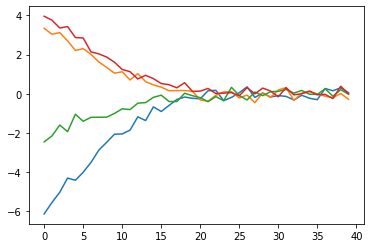

In [ ]:
r = dummy_data_generator(30,10,signal_type='trend')
plt.plot(r[0][0,:])
plt.plot(r[1][0,:])
plt.plot(r[2][0,:])
plt.plot(r[3][0,:])

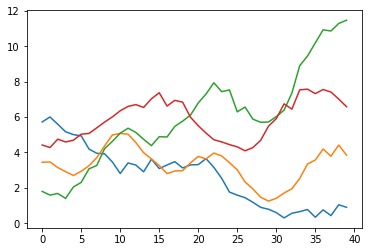

In [ ]:
r = dummy_data_generator(30,10)
plt.plot(r[0][0,:])
plt.plot(r[1][0,:])
plt.plot(r[2][0,:])
plt.plot(r[3][0,:])

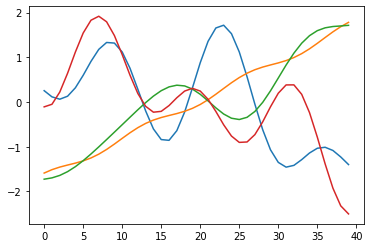

In [ ]:
r = dummy_data_generator(30,10,norm=True, noise = 0)
plt.plot(r[0][0,:])
plt.plot(r[1][0,:])
plt.plot(r[2][0,:])
plt.plot(r[3][0,:])

# Multivariate

In [ ]:
# export 

def dummy_data_generator_multi(length, citys=2, cont = False, signal_type='none',nrows:int=5, random = True, noise = .2, incl_city_trend = False, norm= True, increase_noise = False):

    data = L()
    for city_i in range(citys):
        city_trend = 2* dummy_data_generator(length, 0, signal_type = 'trend', nrows=1, random=random, noise = 0 )[0]  
        for i in range(nrows):
            weather = dummy_data_generator(length-10, 10, signal_type = 'seasonality', nrows=1, random=random, noise = 0 )[0]
            cont = np.random.randn()
            if cont: 
                city_weather = cont * city_trend + weather
            else:
                city_weather = city_trend + weather
            normal_signal = 3 * dummy_data_generator(length//2, length//2, signal_type = signal_type, nrows=1, random=random, noise = noise )[0]                 
            if increase_noise:
                city_weather += dummy_data_generator(2, length-2, signal_type = 'seasonality', nrows=1, random=random, noise = noise,norm=True )[0] * (np.random.randn(length) *(np.arange(length) * (1/length) ) * noise)
            final = normal_signal + city_weather * (1+np.random.randn(length) * .1 * noise)
            if norm:
                final = (final-final.mean())/final.std()
            tot = {'x':final,'weather': weather,'city': city_i}
            if incl_city_trend:
                tot['city_trend']=city_trend
            if cont:
                tot['cont'] = cont
            data.append(tot)           
        
    return pd.DataFrame(data)


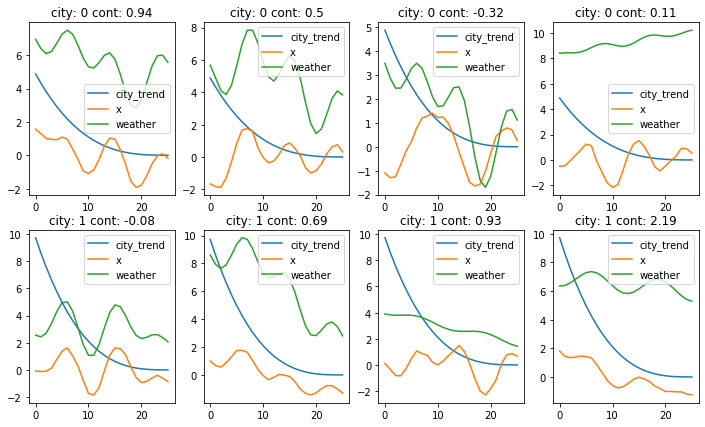

In [ ]:
from fastai2.vision.data import get_grid
df = dummy_data_generator_multi(26, nrows = 4, noise = .1, incl_city_trend = True, cont = True)
ctxs = get_grid(len(df), rows=2, cols=4, add_vert=1)
for i, ctx in enumerate(ctxs):
    for k in ['city_trend', 'x', 'weather']:
        if k in r:      
            ctx.plot(df[k][i][0,:], label= k)
    ctx.set_title(f"city: {str(df['city'][i])} cont: {str(np.round(df['cont'][i],2))}")
    ctx.legend()

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
